In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
!mkdir dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Get the dataset
!unzip /content/drive/MyDrive/temp/balanced_dataset.zip -d /content/dataset

Archive:  /content/drive/MyDrive/temp/balanced_dataset.zip
  inflating: /content/dataset/Normal/Normal (1868).jpg  
  inflating: /content/dataset/Normal/Normal (1044).jpg  
  inflating: /content/dataset/Normal/Normal (3183).jpg  
  inflating: /content/dataset/Normal/Normal (3120).jpg  
  inflating: /content/dataset/Normal/Normal (278).jpg  
  inflating: /content/dataset/Normal/Normal (1916).jpg  
  inflating: /content/dataset/Normal/Normal (2189).jpg  
  inflating: /content/dataset/Normal/Normal (2903).jpg  
  inflating: /content/dataset/Normal/Normal (1981).jpg  
  inflating: /content/dataset/Normal/Normal (469).jpg  
  inflating: /content/dataset/Normal/Normal (2505).jpg  
  inflating: /content/dataset/Normal/Normal (2586).jpg  
  inflating: /content/dataset/Normal/Normal (1357).jpg  
  inflating: /content/dataset/Normal/Normal (2561).jpg  
  inflating: /content/dataset/Normal/Normal (400).jpg  
  inflating: /content/dataset/Normal/Normal (197).jpg  
  inflating: /content/dataset/Nor

In [6]:
!unzip /content/drive/MyDrive/temp/roi_dataset.zip -d /

Archive:  /content/drive/MyDrive/temp/roi_dataset.zip
   creating: /content/split_roi_dataset/
   creating: /content/split_roi_dataset/test/
   creating: /content/split_roi_dataset/test/Pneumonia-Viral/
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (708).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (525).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (774).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (581).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (936).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (1527).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (1563).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (1502).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (555)

vgg16 Model

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization

# Load VGG16 model without the top layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the top layers for fine-tuning
for layer in vgg_base.layers[-4:]:
    layer.trainable = True

x = Flatten()(vgg_base.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)  # Adding batch normalization
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

# Define the new model
model = Model(inputs=vgg_base.input, outputs=output)

# Compile the model with an updated learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [8]:
# prompt: code to check the number of images in a folder

import os

def count_images_in_folder(folder_path):
  """Counts the number of image files in a given folder.

  Args:
    folder_path: The path to the folder containing the images.

  Returns:
    The number of image files in the folder.
  """
  image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')  # Add more if needed
  image_count = 0
  for filename in os.listdir(folder_path):
    if filename.lower().endswith(image_extensions):
      image_count += 1
  return image_count

folder_path = "/content/split_roi_dataset/test/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

folder_path = "/content/split_roi_dataset/train/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

folder_path = "/content/split_roi_dataset/val/Normal"  # Replace with your folder path
num_images = count_images_in_folder(folder_path)
print(f"The number of images in '{folder_path}' is: {num_images}")

The number of images in '/content/split_roi_dataset/test/Normal' is: 167
The number of images in '/content/split_roi_dataset/train/Normal' is: 1324
The number of images in '/content/split_roi_dataset/val/Normal' is: 165


Training on Dataset

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Path to your ROI dataset
train_dir = '/content/split_roi_dataset/train'
val_dir = '/content/split_roi_dataset/val'
test_dir = '/content/split_roi_dataset/test'

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3966 images belonging to 3 classes.
Found 494 images belonging to 3 classes.
Found 499 images belonging to 3 classes.


In [10]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch > 10:  # Lower the learning rate after 10 epochs
        return lr * 0.1
    return lr

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),
    # ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    # LearningRateScheduler(scheduler)
]


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32,
    callbacks=callbacks
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.4712 - loss: 1.3384 - val_accuracy: 0.6771 - val_loss: 0.7599
Epoch 2/100
  1/123 ━━━━━━━━━━━━━━━━━━━━ 57s 472ms/step - accuracy: 0.6562 - loss: 1.1207

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.6562 - loss: 1.1207 - val_accuracy: 0.8571 - val_loss: 0.7478
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 96s 603ms/step - accuracy: 0.6242 - loss: 0.9040 - val_accuracy: 0.6792 - val_loss: 0.6813
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8125 - loss: 0.4734 - val_accuracy: 0.7143 - val_loss: 0.4952
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 76s 597ms/step - accuracy: 0.6641 - loss: 0.8176 - val_accuracy: 0.7167 - val_loss: 0.6770
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7188 - loss: 0.5343 - val_accuracy: 0.7857 - val_loss: 0.4663
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 79s 589ms/step - accuracy: 0.7086 - loss: 0.6975 - val_accuracy: 0.7333 - val_loss: 0.6251
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.7812 - loss: 0.4982 - val_accuracy: 0.7143 - val_loss: 0.5487
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 596ms/step - accuracy: 0.7140 - loss: 0.6668 - va

Testing Metrics

In [12]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 892ms/step - accuracy: 0.7551 - loss: 0.5019
Test accuracy: 74.15%


In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
test_generator.reset()  # Reset test generator if previously used in model.fit
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step


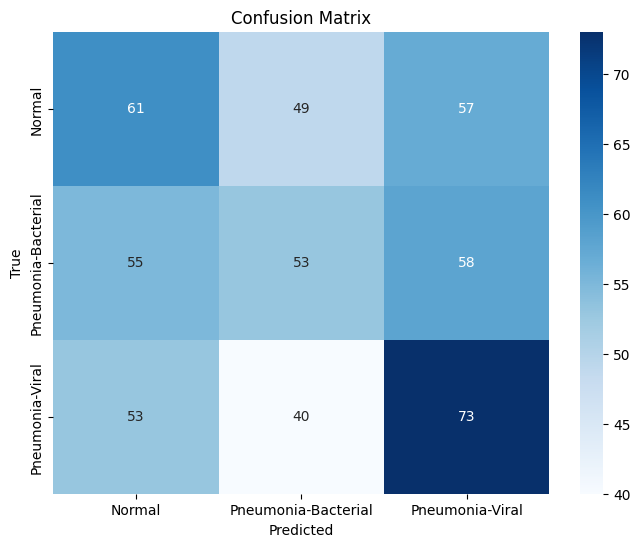

In [14]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [15]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                     precision    recall  f1-score   support

             Normal       0.36      0.37      0.36       167
Pneumonia-Bacterial       0.37      0.32      0.34       166
    Pneumonia-Viral       0.39      0.44      0.41       166

           accuracy                           0.37       499
          macro avg       0.37      0.37      0.37       499
       weighted avg       0.37      0.37      0.37       499

